In [35]:
import copy
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.ndimage.filters import convolve

In [36]:
def rgbtogray(image):
    r,g,b=image[:,:,0],image[:,:,1],image[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

In [37]:
# step 2: apply guassian filter for noise reduction

def get_gaussian_kernel(kernal_size, sigma=1):
    gaussian_kernal = np.zeros((kernal_size, kernal_size), np.float32)
    size = kernal_size//2

    for x in range(-size, size+1):
        for y in range(-size, size+1):
            a = 1/(2*np.pi*(sigma**2))
            b = np.exp(-(x**2 + y**2)/(2* sigma**2))
            gaussian_kernal[x+size, y+size] = a*b
    return gaussian_kernal/gaussian_kernal.sum()

In [38]:
def apply_filtering(input_image, kernal):
    
    output_image = []
    kernal_size = len(kernal)
    kernal_half = kernal_size // 2
    rows_count = len(input_image)
    columns_count = len(input_image[0])

    image_copy = copy.deepcopy(input_image)

    # wrap the image in the edge pixels
    for i in range(rows_count):
        for j in range(kernal_half): 
            image_copy[i].insert(0, input_image[i][-1-j])
            image_copy[i].append(input_image[i][j])
    for i in range(kernal_half):
        image_copy.append(image_copy[2*i])
        image_copy.insert(0, image_copy[-2-2*i].copy())

    # apply filtering
    new_rows_count = len(image_copy)
    new_columns_count = len(image_copy[0])

    for i in range(kernal_half, new_rows_count - kernal_half):
        output_row = []
        for j in range(kernal_half, new_columns_count - kernal_half):
            sum = 0
            for x in range(len(kernal)):
                for y in range(len(kernal)):
                    x1 = i + x - kernal_half
                    y1 = j + y - kernal_half
                    sum += image_copy[x1][y1] * kernal[x][y]
            output_row.append(sum)
        output_image.append(output_row)

    return output_image

In [39]:
# step 3 : gradient estimation

def gradient_estimate(image, gradient_estimation_filter_type):

    if (gradient_estimation_filter_type=="sobel"):
        Mx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
        My = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    elif (gradient_estimation_filter_type=="prewitt"):
        Mx = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]], np.float32)
        My = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]], np.float32)
    else:
        Mx = np.array([[0, 1], [-1, 0]], np.float32)
        My = np.array([[1, 0], [0, -1]], np.float32)

    X = apply_filtering(image, Mx)
    Y = apply_filtering(image, My)

    G = np.hypot(X, Y)
    G = G / G.max() * 255
    theta = np.arctan2(Y, X)

    return (G, theta)

In [40]:
# step 4 : non-maxima suppression to thin out the edges

def non_maxima_suppression(image, gradient_direction):
    rows_count = len(image)
    columns_count = len(image[0])

    output_image = np.zeros((rows_count, columns_count), dtype=np.int32)
    theta = gradient_direction * 180. / np.pi
    theta[theta < 0] += 180

    
    for i in range(1, rows_count-1):
        for j in range(1, columns_count-1):
            next = 255
            previous = 255
            if (0 <= theta[i,j] < 22.5) or (157.5 <= theta[i,j] <= 180):
                next = image[i, j+1]
                previous = image[i, j-1]
            elif (22.5 <= theta[i,j] < 67.5):
                next = image[i+1, j-1]
                previous = image[i-1, j+1]
            elif (67.5 <= theta[i,j] < 112.5):
                next = image[i+1, j]
                previous = image[i-1, j]
            elif (112.5 <= theta[i,j] < 157.5):
                next = image[i-1, j-1]
                previous = image[i+1, j+1]

            if (image[i,j] >= next) and (image[i,j] >= previous):
                output_image[i,j] = image[i,j]
            else:
                output_image[i,j] = 0
    
    return output_image

In [41]:
def double_threshold(image, low_threshold_ratio, high_threshold_ratio):
    
    high_threshold = image.max() * high_threshold_ratio;
    low_threshold = high_threshold * low_threshold_ratio;
    
    rows_count = len(image)
    columns_count = len(image[0])
    output_image = np.zeros((rows_count, columns_count), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)

    strong_i = []
    strong_j = []
    weak_i = [] 
    weak_j = []
    for i in range (len(image)):
        for j in range (len(image[0])):
            if (image[i,j]>=high_threshold):
                strong_i.append(i)
                strong_j.append(j)
            if ((image[i,j] <= high_threshold) & (image[i,j] >= low_threshold)):
                weak_i.append(i)
                weak_j.append(j)
    strong_i = np.array(strong_i)
    strong_j = np.array(strong_j)
    weak_i = np.array(weak_i)
    weak_j = np.array(weak_j)
    
    output_image[strong_i, strong_j] = strong
    output_image[weak_i, weak_j] = weak


    
    return (output_image, weak, strong)

In [42]:
def hysteresis_edge_track(image, weak, strong=255):
    rows_count = len(image)
    columns_count = len(image[0]) 
    for i in range(1, rows_count-1):
        for j in range(1, columns_count-1):
            if (image[i,j] == weak):
                if ((image[i+1, j-1] == strong) or (image[i+1, j] == strong) or (image[i+1, j+1] == strong)
                    or (image[i, j-1] == strong) or (image[i, j+1] == strong)
                    or (image[i-1, j-1] == strong) or (image[i-1, j] == strong) or (image[i-1, j+1] == strong)):
                    image[i, j] = strong
                else:
                    image[i, j] = 0
    return image

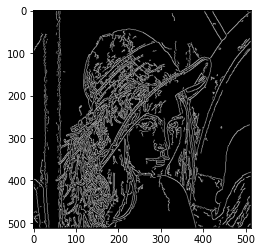

In [47]:

kernal_size = 3
low_threshold_ratio = 0.05
high_threshold_ratio = 0.09
gradient_estimation_filter_type = "sobel"
# load image
image = cv2.imread("Lenna_(test_image) (3).png")

# step 1 : convert image to gray scale
gray_scaled_image = rgbtogray(image)

# step 2 : apply gaussian kernal to filter noise
kernal = get_gaussian_kernel(kernal_size)
image_without_noise = apply_filtering(gray_scaled_image.tolist(), kernal)

# step 3 : gradient estimation
assert (gradient_estimation_filter_type in ["sobel", "prewitt", "robert"]), "gradient estimation filter type should be [\"prewitt\", \"sobel\", \"robert\"]"
G, theta = gradient_estimate(image_without_noise, gradient_estimation_filter_type)

# step 4 : non maxima suppression
image_with_thin_edges = non_maxima_suppression(G, theta)

# step 5 : double threshold
final_image, weak, strong = double_threshold(image_with_thin_edges, low_threshold_ratio, high_threshold_ratio)

# edge tracking with hysteresis
img = hysteresis_edge_track(final_image, weak, strong=255)
plt.imshow(np.array(img),cmap="gray")
